In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import scipy.special as sps
from scipy.stats import multivariate_normal
%matplotlib inline

# 3a. Multivariate Normal Gibbs Sampler

In [2]:
def sample_conditional(x, d, mu, sigma):
    """update x[d] conditional on the values x[-d]"""
    sigma_cross = np.delete(sigma[d,:], d)
    sigma_no_d = np.delete(np.delete(sigma, d, axis=0), d, axis=1)
    mu_d = mu[d] + np.dot(np.dot(sigma_cross.T,
                                 np.linalg.inv(sigma_no_d)),
                          np.delete(x, d) - np.delete(mu, d))
    var_d = sigma[d,d] - np.dot(np.dot(sigma_cross, 
                                           np.linalg.inv(sigma_no_d)), 
                                    sigma_cross)
    return npr.randn() * np.sqrt(var_d) + mu_d

def sample_mvn_gibbs(mu, sigma, n_samples):
    """Generate N samples from a mean mu, covariance sigma multivariate normal distribution via Gibbs Sampling"""
    
    # initialize with mean
    curr_sample = np.copy(mu)
    samples = np.empty([n_samples, len(mu)])
    
    for n in range(n_samples): # Generate n consecutive samples
        for d in range(len(mu)): # Iterate over coordinates
            curr_sample[d] = sample_conditional(curr_sample, d, mu, sigma)
        samples[n,:] = curr_sample
    return samples

# 3b. Testing the Sampler 

In [3]:
def plot_samples(samples, mu, sigma, xlim=[-2,4], ylim=[-5,7]):
    # Plot Contours Of Target PDF
    x, y = np.mgrid[xlim[0]:xlim[1]:.1, ylim[0]:ylim[1]:.1]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y
    rv = multivariate_normal([1., 1.], [[1., 1.], [1., 5.]])
    pdf_at_1std = rv.pdf(np.hstack([np.sqrt(sigma[0,0]) + mu[0], mu[1:]]))
    plt.contour(x, y, rv.pdf(pos), colors='black', levels=pdf_at_1std)
    # Plot Samples
    plt.scatter(samples[:,0], samples[:,1], color='r', marker='.', alpha= .75)

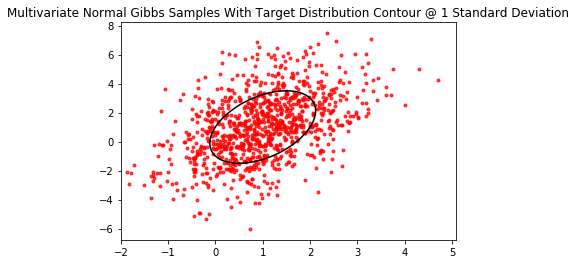

In [4]:
mu = np.array([1., 1.])
sigma = np.array([[1., 1.],[1.,5.]])
N = 1000
plot_samples(sample_mvn_gibbs(mu, sigma, N), mu, sigma)
plt.title("Multivariate Normal Gibbs Samples With Target Distribution Contour @ 1 Standard Deviation")
plt.show()

# 3c. Ring Model Gibbs Sampler

In [5]:
def sample_ring_gibbs(theta, n_samples, burn_in=100):
    """Sample from cyclic graph using a Gibbs sampler and an approximation to the conditionals"""
    
    d = len(theta)
    samples = np.empty((n_samples, d))
    burn = np.empty((burn_in, d))
    
    # initialize uniformly at random
    curr_sample = npr.choice([1,0], size=d, replace=True, p=[.5,.5])  
    
    for n in range(n_samples + burn_in):  # Record N consecutive samples after burn in
        for i in range(d):  # Iterate over coordinates
            
            # [P(x_i = 1 | x_{i-1}), P(x_i = 0 | x_{i-1})]
            probas_pre = np.array([sps.expit(theta[i-1] * curr_sample[i-1]),  
                                   1 - sps.expit(theta[i-1] * curr_sample[i-1])])
            
            # [P(x_{i+1} = 1 | x_i = 1), P(x_{i+1} = 1 | x_i = 0)]
            probas_post = np.array([sps.expit(theta[i]),
                                    sps.expit(0)])
            
            # [P(x_{i+1} = 0 | x_i = 1), P(x_{i+1 = 0 | x_i = 0)]
            if curr_sample[(i+1) % d] == 0: probas_post = 1 - probas_post
            
            # P(x_i | x_{-i}) \propto P(x_i | x_{i-1}) * P(x_{i+1} | x_i) 
            curr_sample[i] = npr.choice([1, 0], p=(probas_pre * probas_post) / np.sum(probas_pre * probas_post))
        
        # Only record samples after burn in period
        if n >= burn_in:
            samples[n - burn_in, :] = curr_sample
        else:
            burn[n,:] = curr_sample
            
    return (samples, burn) 

We can now generate samples from this distribution and use them to estimate probabilities such as $P(X_1 = X_2)$.

In [6]:
N_samp = 1000
N_burn = 20
samples, burn_in = sample_ring_gibbs(theta=[1/3,1/3,1/3,1/3,1/3,1/3], n_samples=N_samp, burn_in=N_burn)
prob = sum(samples[-N_burn:,0] == samples[-N_burn:,1])/N_burn 
print("P(X_1 = X_2) is approximately {}".format(prob)) #This is the probability that X1 equals X2

P(X_1 = X_2) is approximately 0.55


Note that it is unimportant how the students compare before/after burn-in as the sampler converges very fast.